# Performance Metrics for the following:
### 1. Model predictions on custom test set
### 2. Predictive assistant accuracy & impact

## Predictions on test set

In [1]:
import os
import sys
import cv2
from ultralytics import YOLO

sys.path.append(os.path.abspath('../utils'))
import screen_info
import annotation_utils

In [2]:
window_width, window_height, window_x, window_y = screen_info.get_screen_info()

In [3]:
model_dir = "../models"
models = [f for f in os.listdir(model_dir) if os.path.isfile(os.path.join((model_dir), f))]
print(models)

color_map = {
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (0, 255, 255)
}

testing_dir = "../data/images/testing"
testing_label_dir = "../data/labels/testing"

iou_threshold = 0.85
# precision values
ps = []

# recall values
rs = []

# f1 scores
f1s = []


['2025-02-28_00-52-42.pt', '2025-02-28_12-21-42.pt', '2025-03-01_17-41-01.pt', '2025-03-03_21-42-59.pt', '2025-03-05_15-00-04.pt', '2025-03-05_17-47-25.pt', '2025-03-05_20-58-33.pt', '2025-03-05_21-45-32.pt', '2025-03-06_16-08-18.pt', '2025-03-06_19-39-58.pt', '2025-03-06_21-49-18.pt', '2025-03-08_12-13-49.pt', '2025-03-08_15-07-30.pt', '2025-03-08_17-09-50.pt', '2025-03-10_17-41-22.pt', '2025-03-13_15-51-01.pt', '2025-03-14_13-01-57.pt', 'augmented_test_1.pt', 'augmented_test_2.pt']


In [4]:
FNs = []
FPs = []
TPs = []
for mdl in models:
    TP = 0
    FP = 0
    FN = 0
    model_path = os.path.join(model_dir, mdl)
    model = YOLO(model_path)

    test_imgs = os.listdir(testing_dir)
    for test in test_imgs:

        # gather all the ground truth labels
        annotations = []
        with open(os.path.join(testing_label_dir, test.split('.')[0] + '.txt'), 'r') as file:
            for line in file:
                annotations.append(line.strip())
        img = cv2.imread(os.path.join(testing_dir, test))
        h, w, _ = img.shape
        ground_truths = []
        for ann in annotations:
            ann = ann.split()
            class_id = int(ann[0])
            x_center = float(ann[1])
            y_center = float(ann[2])
            width = float(ann[3])
            height = float(ann[4])
            x1 = w * (x_center - (width/2))
            x2 = w * (x_center + (width/2))
            y1 = h * (y_center - (height/2))
            y2 = h * (y_center + (height/2))

            ground_truths.append([x1, y1, x2, y2, class_id])
        
        matched_gt = []

        # run predictions on picture, compare predictions to GT labels 
        results = model.predict(os.path.join(testing_dir, test), verbose=False)[0]
        predictions = results.boxes.data.tolist()
        for pred in predictions:
            best_iou = 0
            best_gt = None

            # iterate over each ground truth label and compare it to the current prediciton
            for i, gt in enumerate(ground_truths):
                
                # ground trutch label already matched
                if i in matched_gt:
                    continue 

                if int(pred[-1]) == int(gt[-1]):
                    iou = annotation_utils.iou(pred[:-1], gt[:-1])
                    if iou > best_iou:
                        best_iou = iou
                        best_gt = i

            if best_gt is not None and best_iou > iou_threshold:
                TP += 1
                matched_gt.append(best_gt)
            else:
                FP += 1
    
        FN += len(ground_truths) - len(matched_gt)
    FNs.append(FN)
    TPs.append(TP)
    FPs.append(FP)
    precision = TP / (FP + TP) if  (TP + FP) > 0 else 0
    recall = TP / (FN + TP) if (TP + FN) > 0 else 0 
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 
    ps.append(precision)
    rs.append(recall)
    f1s.append(f1_score)



In [5]:
print(FNs)
print(TPs)
print(FPs)


[652, 559, 614, 589, 605, 516, 465, 545, 516, 472, 430, 411, 417, 391, 327, 276, 277, 244, 253]
[124, 217, 162, 187, 171, 260, 311, 231, 260, 304, 346, 365, 359, 385, 449, 500, 499, 532, 523]
[24, 100, 57, 49, 131, 84, 87, 26, 27, 29, 39, 38, 35, 38, 43, 44, 34, 58, 24]


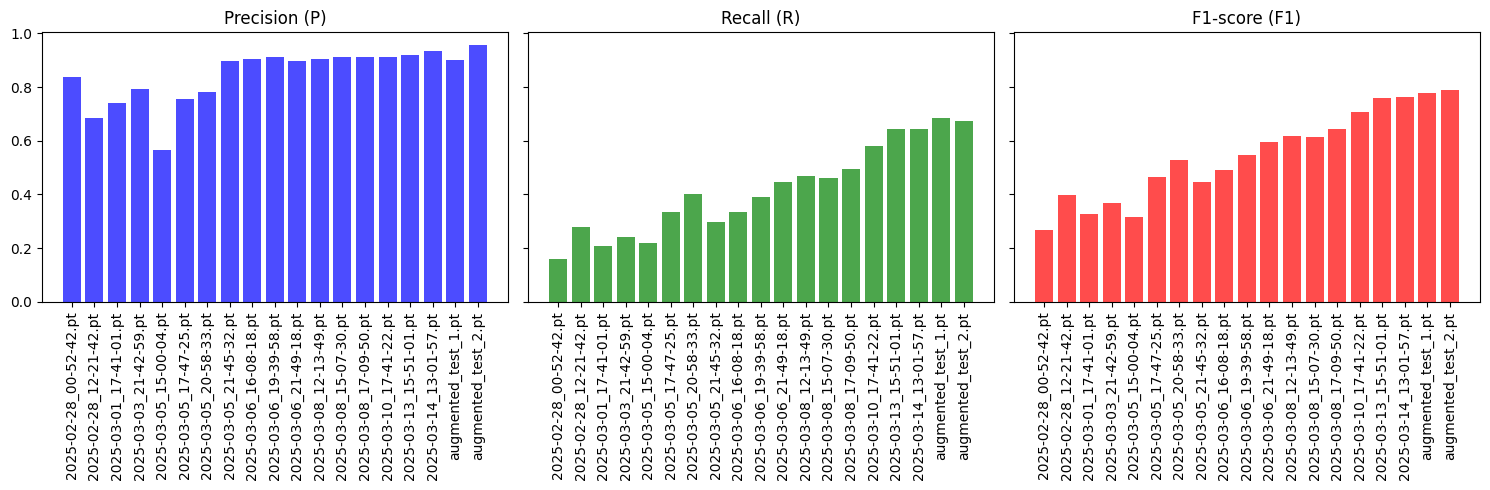

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data

# X-axis positions
x = np.arange(len(models))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Precision plot
axes[0].bar(x, ps, color='blue', alpha=0.7)
axes[0].set_title("Precision (P)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=90)

# Recall plot
axes[1].bar(x, rs, color='green', alpha=0.7)
axes[1].set_title("Recall (R)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=90)

# F1-score plot
axes[2].bar(x, f1s, color='red', alpha=0.7)
axes[2].set_title("F1-score (F1)")
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=90)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


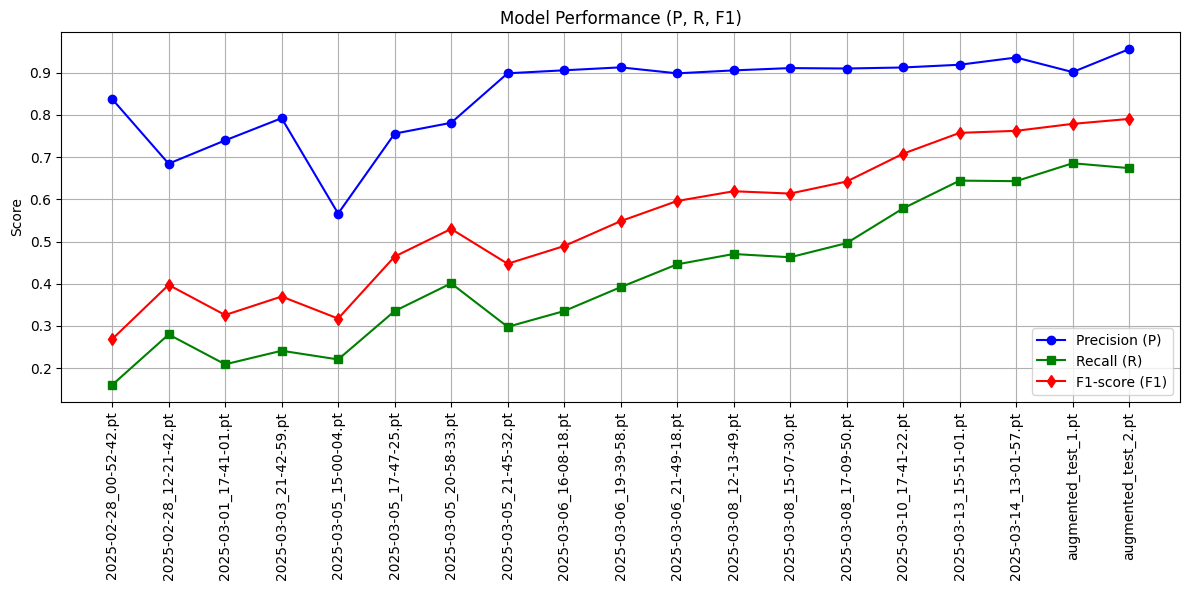

In [7]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis positions (keeping the order)
x = np.arange(len(models))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Precision, Recall, and F1-score as line graphs
plt.plot(x, ps[:19], marker='o', linestyle='-', color='blue', label='Precision (P)')
plt.plot(x, rs[:19], marker='s', linestyle='-', color='green', label='Recall (R)')
plt.plot(x, f1s[:19], marker='d', linestyle='-', color='red', label='F1-score (F1)')

# Labeling
plt.xticks(x, models, rotation=90)
plt.ylabel("Score")
plt.title("Model Performance (P, R, F1)")
plt.legend()

# Show the graph
plt.grid(True)
plt.tight_layout()
plt.show()


### View results of predictions vs ground truth labels for a particular model

In [ ]:
import numpy as np
model_name = '2025-03-14_13-01-57.pt'
model_path = os.path.join(model_dir, model_name)

model = YOLO(model_path)

test_imgs = os.listdir(testing_dir)


for test in test_imgs:
    pred_img = cv2.imread(os.path.join(testing_dir, test))
    results = model.predict(os.path.join(testing_dir, test), verbose=False)[0]
    predictions = results.boxes.data.tolist()

    for pred in predictions:
        x1, y1, x2, y2, score, class_id = pred
        cv2.rectangle(pred_img, (int(x1), int(y1)), (int(x2), int(y2)), color_map[int(class_id)], 1)
        cv2.putText(pred_img, str(100*round(score,2)), (int(x1), int(y1)-20), cv2.FONT_HERSHEY_PLAIN, 0.9, color_map[int(class_id)], 1)

    gt_labels = []
    gt_path = os.path.join(testing_label_dir, test.split(".")[0] + '.txt')
    with open(gt_path, 'r') as file:
        for line in file:
            ann_map = {}
            keys = line.split(' ')
            ann_map['class'] = int(keys[0])
            ann_map['x_center'] = float(keys[1])
            ann_map['y_center'] = float(keys[2])
            ann_map['width'] = float(keys[3])
            ann_map['height'] = float(keys[4].replace('\n', ''))
            annotations.append(ann_map)
            gt_labels.append(ann_map)

    true_img = cv2.imread(os.path.join(testing_dir, test))

    h, w, _ = true_img.shape

    for label in gt_labels:
        
        class_id = label['class']
        x_center = label['x_center']
        y_center = label['y_center']
        width = label['width']
        height = label['height']

        x1 = int(w * (x_center - (width/2)))
        y1 = int(h * (y_center - (height/2)))
        x2 = int(w * (x_center + (width/2)))
        y2 = int(h * (y_center + (height/2)))

        cv2.rectangle(true_img, (x1, y1), (x2, y2), color_map[class_id], 1)

    new_width = w * 2
    new_height = h
    combined_image = np.zeros((new_height, new_width, 3), np.uint8)

    combined_image[:h, :w, :] = true_img
    combined_image[:h, w:new_width, :] = pred_img

    window_name = f"{test}:    Ground Truth vs Predictions"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)  # Allow resizing
    cv2.resizeWindow(window_name, window_width, window_height)  # Set to 95% of screen size
    cv2.waitKey(1)
    cv2.moveWindow(window_name, window_x, window_y)  # Center it on the second monitor
    exit = False
    while True:
        cv2.imshow(window_name, combined_image)
        key = cv2.waitKey(10) & 0xFF
        if key == 27:
            exit = True
            break
        elif key == ord('q'):
            break
    cv2.destroyAllWindows()
    if exit:
        break
        
    cv2.destroyAllWindows()
        


KeyboardInterrupt: 

: 

## View Prediction Assitant Performance

In [9]:
import json
import os

ann_meta_data_dir = "../annotation_meta_data"

annotation_files = os.listdir(ann_meta_data_dir)

tallies = []

for ann_file in annotation_files:
    with open(os.path.join(ann_meta_data_dir, ann_file), 'r') as file:
        data = json.load(file)
    sum_total_preds = 0
    sum_total_removed = 0
    sum_kept_pred_red = 0
    sum_kept_pred_yellow = 0
    sum_kept_pred_green = 0
    sum_total_pred_red = 0
    sum_total_pred_yellow = 0
    sum_total_pred_green = 0 
    sum_total_inst_red = 0
    sum_total_inst_yellow = 0
    sum_total_inst_green = 0
    sum_total_kept_pred = 0
    sum_total_inst_all = 0

    tally = {}
    
    for image, annotation in data.items():
        for key, value in annotation.items():
            tally[key] = tally.get(key, 0) + value

    total_preds = tally['pred_red_light'] + tally['pred_yellow_light'] + tally['pred_green_light']
    sum_total_preds += total_preds

    total_removed = tally['rmv_red_light'] + tally['rmv_yellow_light'] + tally['rmv_green_light']
    sum_total_removed += total_removed

    kept_pred_red = tally['pred_red_light'] - tally['rmv_red_light'] 
    sum_kept_pred_red += kept_pred_red
    kept_pred_yellow = tally['pred_yellow_light'] - tally['rmv_yellow_light'] 
    sum_kept_pred_yellow += kept_pred_yellow
    kept_pred_green = tally['pred_green_light'] - tally['rmv_green_light'] 
    sum_kept_pred_green += kept_pred_green

    total_pred_red = tally['pred_red_light']
    sum_total_pred_red += total_pred_red
    total_pred_yellow = tally['pred_yellow_light']
    sum_total_pred_yellow += total_pred_yellow
    total_pred_green = tally['pred_green_light']
    sum_total_pred_green += total_pred_green

    total_inst_red = tally['red_light']
    sum_total_inst_red += total_inst_red
    total_inst_yellow = tally['yellow_light']
    sum_total_inst_yellow += total_inst_yellow
    total_inst_green = tally['green_light']
    sum_total_inst_green += total_inst_green

    total_kept_pred = kept_pred_red + kept_pred_yellow + kept_pred_green
    sum_total_kept_pred += total_kept_pred
    total_inst_all = tally['total_annotations']
    sum_total_inst_all += total_inst_all

    retention = (total_preds - total_removed) / total_preds if total_preds != 0 else 0

    precision_red = kept_pred_red / total_pred_red if total_pred_red != 0 else 0
    precision_yellow = kept_pred_yellow / total_pred_yellow if total_pred_yellow != 0 else 0
    precision_green = kept_pred_green / total_pred_green if total_pred_green != 0 else 0
    total_precision = total_kept_pred / total_preds

    coverage_red = kept_pred_red / total_inst_red if total_inst_red != 0 else 0
    coverage_yellow = kept_pred_yellow / total_inst_yellow if total_inst_yellow != 0 else 0
    coverage_green = kept_pred_green / total_inst_green if total_inst_green != 0 else 0

    reduction = total_kept_pred / total_inst_all if total_inst_all != 0 else 0

    false_pos = total_removed / total_preds if total_preds != 0 else 0

    recall = total_kept_pred / total_inst_all
    tallies.append({
        'ann_file': ann_file,
        'recall': round(recall, 3),
        'tot_prec': round(total_precision, 3),
        'ret': round(retention, 3),
        'prec_red': round(precision_red, 3),
        'prec_yel': round(precision_yellow, 3),
        'prec_green': round(precision_green, 3),
        'cov_red': round(coverage_red, 3),
        'cov_yel': round(coverage_yellow, 3),
        'cov_green': round(coverage_green, 3),
        'reduc': round(reduction, 3),
        'fp': round(false_pos, 3) 
    })

for t in tallies:
    print(t)

print(f'Percent of workload reduced = {100 * round(float(sum_total_kept_pred / sum_total_inst_all), 2)}%')

{'ann_file': '2025-03-03_21-42-59.json', 'recall': 0.14, 'tot_prec': 0.665, 'ret': 0.665, 'prec_red': 0.811, 'prec_yel': 0, 'prec_green': 0.0, 'cov_red': 0.14, 'cov_yel': 0, 'cov_green': 0.0, 'reduc': 0.14, 'fp': 0.335}
{'ann_file': '2025-03-05_15-00-04.json', 'recall': 0.627, 'tot_prec': 1.0, 'ret': 1.0, 'prec_red': 1.0, 'prec_yel': 0, 'prec_green': 0, 'cov_red': 0.642, 'cov_yel': 0, 'cov_green': 0.0, 'reduc': 0.627, 'fp': 0.0}
{'ann_file': '2025-03-05_17-47-25.json', 'recall': 0.483, 'tot_prec': 0.621, 'ret': 0.621, 'prec_red': 0.596, 'prec_yel': 0, 'prec_green': 0.858, 'cov_red': 0.912, 'cov_yel': 0.0, 'cov_green': 0.131, 'reduc': 0.483, 'fp': 0.379}
{'ann_file': '2025-03-05_21-45-32.json', 'recall': 0.535, 'tot_prec': 0.816, 'ret': 0.816, 'prec_red': 0.801, 'prec_yel': 0.143, 'prec_green': 0.835, 'cov_red': 0.63, 'cov_yel': 1.0, 'cov_green': 0.49, 'reduc': 0.535, 'fp': 0.184}
{'ann_file': '2025-03-06_16-08-18.json', 'recall': 0.619, 'tot_prec': 0.846, 'ret': 0.846, 'prec_red': 0.87

### Calculate the incremental improvement

In [17]:
recall_differences = [tallies[i]['recall'] - tallies[i-1]['recall'] for i in range(1, len(tallies))]
recall_increment = sum(recall_differences) / len(recall_differences)
print(recall_increment)

prec_differences = [tallies[i]['tot_prec'] - tallies[i-1]['tot_prec'] for i in range(1, len(tallies))]
prec_increment = sum(prec_differences) / len(prec_differences)
print(prec_increment)

0.040100000000000004
0.0252
